In [1]:
!wget  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.ar.zip

--2023-07-04 09:50:05--  https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.ar.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.156.60.102, 108.156.60.51, 108.156.60.36, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.156.60.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4243104161 (4.0G) [application/zip]
Saving to: ‘wiki.ar.zip’

wiki.ar.zip         100%[===================>]   3.95G  26.7MB/s    in 2m 38s  

2023-07-04 09:52:44 (25.7 MB/s) - ‘wiki.ar.zip’ saved [4243104161/4243104161]



In [2]:
import requests, zipfile, io
z = zipfile.ZipFile("/content/wiki.ar.zip")
z.extractall()

In [1]:
#For Pre-Processing
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
import os, re, csv, math, codecs


# For Training
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

# For array, dataset, and visualizing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
np.random.seed(0)

MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(nltk.corpus.stopwords.words("arabic"))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
print('loading word embeddings...')

embeddings_index = {}
f = codecs.open('/content/wiki.ar.vec', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))

loading word embeddings...


610979it [01:22, 7400.64it/s]

found 610978 word vectors


In [3]:
from sklearn.model_selection import train_test_split
df_Spam = pd.read_excel("SpamTweets_S.xlsx")
df_Ham = pd.read_excel("HamTweets_S.xlsx")
df_Spam = df_Spam[['Cleaned Text','Label']]
df_Ham = df_Ham[['Cleaned Text','Label']]
df_Spam = df_Spam.drop_duplicates(subset="Cleaned Text")
df_Ham = df_Ham.drop_duplicates(subset="Cleaned Text")
df = pd.concat([df_Spam, df_Ham])

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df.Label.values)

<ipython-input-4-102c818331cb>:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['doc_len'], hist=True, kde=True, color='b', label='doc len')


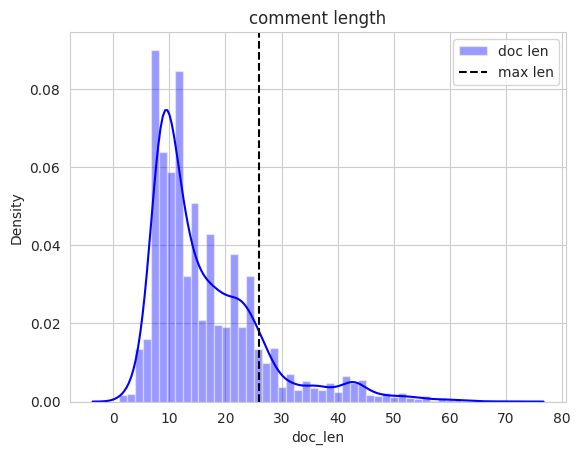

In [4]:
label_names = ["Label"]
y_train = train_df[label_names].values

train_df['doc_len'] = train_df['Cleaned Text'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)

sns.distplot(train_df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

In [5]:
from sklearn.utils import shuffle
from keras.utils import pad_sequences

raw_docs_train = train_df['Cleaned Text'].tolist()
raw_docs_test = test_df['Cleaned Text'].tolist()
num_classes = len(label_names)

print("pre-processing train data...")

processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = keras.utils.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = keras.utils.pad_sequences(word_seq_test, maxlen=max_seq_len)

pre-processing train data...


100%|██████████| 2653/2653 [00:00<00:00, 8929.69it/s]


tokenizing input data...
dictionary size:  30973


In [6]:
#training params
batch_size = 256
num_epochs = 40

#model parameters
num_filters = 64
embed_dim = 300
weight_decay = 1e-4

In [7]:
#embedding matrix

print('preparing embedding matrix...')

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 7231


In [8]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['طلبالعلاج' 'براندنبيرغ' 'لمنصه' 'ارهابيتين' 'يحذران' 'والاطلسي' 'المنوح'
 'دريدلحام' 'الاسو' 'تعرضي']


In [9]:
len(words_not_found)

7230

In [10]:
from keras.layers import BatchNormalization
import tensorflow as tf

model = keras.Sequential()

model.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))

model.add(Dropout(0.3))
model.add(Dense(32,activation='relu'))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 26, 300)           9292200   
                                                                 
 dropout (Dropout)           (None, 26, 300)           0         
                                                                 
 dense (Dense)               (None, 26, 32)            9632      
                                                                 
 bidirectional (Bidirectiona  (None, 26, 128)          49664     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 26, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 26, 128)          9

In [11]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[recall_m,precision_m,f1_m])

In [13]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(word_seq_train, y_train, batch_size=64,
          epochs=num_epochs, validation_split=0.3, shuffle=False)

Epoch 1/40
117/117 [==============================] - 29s 62ms/step - loss: 0.2274 - recall_m: 0.6455 - precision_m: 0.6846 - f1_m: 0.6467 - val_loss: 0.0817 - val_recall_m: 0.8986 - val_precision_m: 0.9229 - val_f1_m: 0.9079
Epoch 2/40
117/117 [==============================] - 3s 27ms/step - loss: 0.0978 - recall_m: 0.8869 - precision_m: 0.9236 - f1_m: 0.8957 - val_loss: 0.0591 - val_recall_m: 0.9263 - val_precision_m: 0.9428 - val_f1_m: 0.9316
Epoch 3/40
117/117 [==============================] - 3s 28ms/step - loss: 0.0647 - recall_m: 0.9216 - precision_m: 0.9596 - f1_m: 0.9370 - val_loss: 0.0596 - val_recall_m: 0.9513 - val_precision_m: 0.9335 - val_f1_m: 0.9393
Epoch 4/40
117/117 [==============================] - 3s 28ms/step - loss: 0.0509 - recall_m: 0.9458 - precision_m: 0.9649 - f1_m: 0.9516 - val_loss: 0.0525 - val_recall_m: 0.9527 - val_precision_m: 0.9441 - val_f1_m: 0.9458
Epoch 5/40
117/117 [==============================] - 4s 33ms/step - loss: 0.0450 - recall_m: 0.953

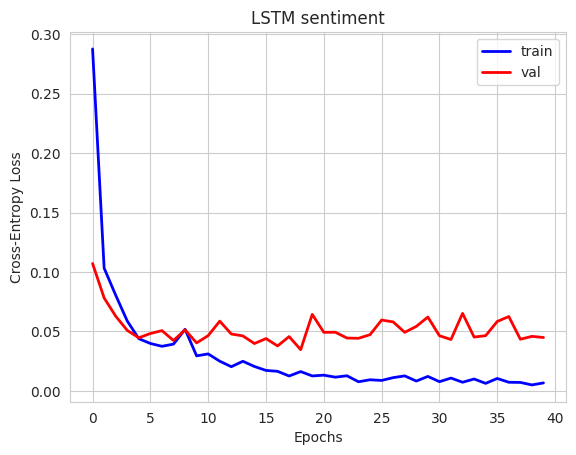

In [20]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('LSTM sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

In [14]:
y_test = test_df[label_names].values
model.evaluate(word_seq_test, y_test)

83/83 [==============================] - 1s 11ms/step - loss: 0.0334 - recall_m: 0.9521 - precision_m: 0.9946 - f1_m: 0.9703


[0.03342128172516823, 0.9520748257637024, 0.9946452975273132, 0.97030109167099]